# RNN for PTB Dataset
The goal of this notebook is to create a RNN architecture for the PTB Diagnostic ECG Database: https://www.physionet.org/content/ptbdb/1.0.0/  
The data was downloaded from kaggle: https://www.kaggle.com/shayanfazeli/heartbeat

We compare the results obtained with the trained RNN network (with only LSTM and dense layers) with the CNN baseline.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.engine.saving import load_model
from sklearn.metrics import accuracy_score, f1_score, roc_curve, precision_recall_curve, \
roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


# Read data

In [2]:
data_path_normal =  "../input/ptbdb_normal.csv"
data_path_abnormal = "../input/ptbdb_abnormal.csv"

In [3]:
df_1 = pd.read_csv(data_path_normal, header=None)
df_2 = pd.read_csv(data_path_abnormal, header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

# Baseline results

In [4]:
def get_baseline_resuts():
    Y = np.array(df_train[187].values).astype(np.int8)
    X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

    Y_test = np.array(df_test[187].values).astype(np.int8)
    X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    file_path = "../saved_trained_models/baseline_cnn_ptb.h5"

    model = load_model(file_path)

    pred_test_prob = model.predict(X_test)
    pred_test = (pred_test_prob>0.5).astype(np.int8)

    f1 = f1_score(Y_test, pred_test)
    acc = accuracy_score(Y_test, pred_test)

    return pred_test_prob, pred_test, f1, acc

# Compare RNN with baseline

In [5]:
num_classes = 2
timepoints_per_sample = 187

# normalize without taking the zero-padding at the end into account:
for sample_idx in range(X.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X[sample_idx, 0: first_zero_sample, 0] -= np.mean(X[sample_idx, 0: first_zero_sample, 0])
    X[sample_idx, 0: first_zero_sample, 0] /= np.std(X[sample_idx, 0: first_zero_sample, 0])

for sample_idx in range(X_test.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X_test[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X_test[sample_idx, 0: first_zero_sample, 0] -= np.mean(X_test[sample_idx, 0: first_zero_sample, 0])
    X_test[sample_idx, 0: first_zero_sample, 0] /= np.std(X_test[sample_idx, 0: first_zero_sample, 0])

In [6]:
# final evaluation on test set
file_path = "../saved_trained_models/own_lstm_ptb.h5"
model = load_model(file_path)
rnn_pred_test_prob = model.predict(X_test)
rnn_pred_test = (rnn_pred_test_prob > 0.5).astype(np.int8)

rnn_f1 = f1_score(Y_test, rnn_pred_test)
rnn_acc = accuracy_score(Y_test, rnn_pred_test)

In [7]:
base_pred_test_prob, base_pred_test, base_f1, base_acc = get_baseline_resuts()

In [8]:
stats = pd.DataFrame({"model":[ "baseline","RNN"], "accuracy":[base_acc, rnn_acc], "f1_score":[base_f1, rnn_f1]})

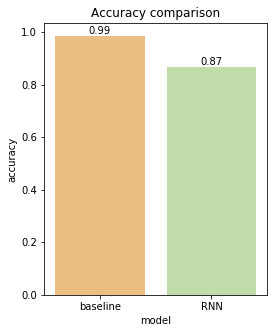

In [9]:
plt.figure(figsize=(4, 5))
splot = sns.barplot(x="model", y="accuracy", data=stats, palette="Spectral")
plt.title("Accuracy comparison")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

The RNN performs significantly worse in terms of accuracy (-0.12).

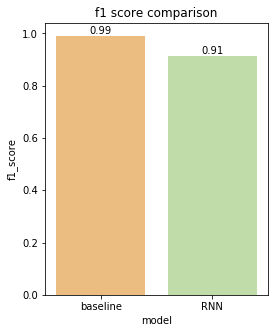

In [10]:
plt.figure(figsize=(4, 5))
splot = sns.barplot(x="model", y="f1_score", data=stats, palette="Spectral")
plt.title("f1 score comparison")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

The RNN performs worse by 0.08 in f1 score.

In [11]:
def plot_roc_curve(labels, predictions, rnn_predictions):
    fp, tp, _ = roc_curve(labels, predictions)
    rnn_fp, rnn_tp, _ = roc_curve(labels, rnn_predictions)

    sns.lineplot(100*fp, 100*tp, label="baseline, AUC = {0:.2f}".\
               format(roc_auc_score(labels, predictions)))
    sns.lineplot(100*rnn_fp, 100*rnn_tp, label="RNN, AUC = {0:.2f}".\
               format(roc_auc_score(labels, rnn_predictions)))
    plt.title("ROC curve")
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.show()

def plot_precision_recall_curve(labels, predictions, rnn_predictions):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    rnn_precision, rnn_recall, _ = precision_recall_curve(labels, rnn_predictions)

    sns.lineplot(recall, precision, label="baseline, AP = {0:.2f}".\
               format(average_precision_score(labels, predictions)))
    sns.lineplot(rnn_recall, rnn_precision, label="RNN, AP = {0:.2f}".\
               format(average_precision_score(labels, rnn_predictions)))
    plt.title("Precision-recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()


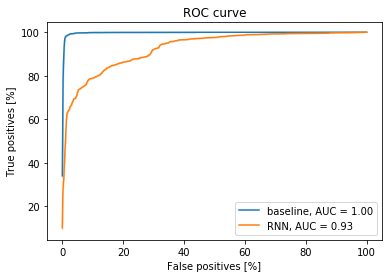

In [12]:
plot_roc_curve(Y_test, base_pred_test_prob, rnn_pred_test_prob)

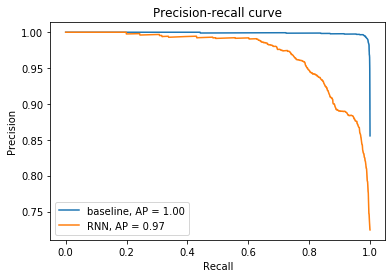

In [13]:
plot_precision_recall_curve(Y_test, base_pred_test_prob, rnn_pred_test_prob)

The results suggest than a simple LSTM network might not be be a good model choice.